In [1]:
# Threading
# To start Julia with 8 threads on PC, open anaconda prompt and run <set JULIA_NUM_THREADS=8>, then run <jupyter notebook>
ENV["JULIA_NUM_THREADS"] = 8 # Don't need to run on mac - set nthreads in VScode
Threads.nthreads()

8

In [3]:
using IRQIV
import PyPlot as plt
import Statistics, NaNStatistics
plt.pygui(false) # sets plots to popup instead of inline

false

In [4]:
# On PC 7/4/24: 
# re-installed IRQIV to desktop since Box installation not syncing to PC, ran Pkg.develop() on new path
# installed same Julia version as on Mac (1.9.3), installed IJulia to sync kernel to Jupyter

In [4]:
# FLIR_filename = joinpath(raw"/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-003504.ats")
FLIR_filename = joinpath(raw"D:\CNRD_IR\Rec-DeFreesLab_-003504.ats")
Img_dims = [784, 1344]
DtFrames = 1
nImagePairs = Inf

# set range to average over and load images
inds = range(1, step=1, length=100)
raw_imgs = LoadATSImageSequence(FLIR_filename, inds, 2022)

IRQIV.FLIRATSFiles.ATSSequence([0x27cd 0x27ce … 0x2793 0x2793; 0x27d7 0x27dd … 0x27b0 0x27a5; … ; 0x289d 0x2885 … 0x2483 0x248b; 0x28a8 0x2888 … 0x248f 0x2487;;; 0x27c7 0x27c3 … 0x2798 0x2796; 0x27d1 0x27d1 … 0x27a1 0x27b1; … ; 0x28a3 0x28a7 … 0x247e 0x2487; 0x28a8 0x2893 … 0x248a 0x2491;;; 0x27d6 0x27e1 … 0x27a6 0x278b; 0x27ed 0x27db … 0x27a1 0x27b4; … ; 0x289a 0x2898 … 0x248f 0x2493; 0x2897 0x287b … 0x2489 0x2490;;; … ;;; 0x27fd 0x280b … 0x2791 0x2791; 0x280d 0x2809 … 0x27aa 0x27b1; … ; 0x2836 0x283e … 0x2486 0x2489; 0x2847 0x2840 … 0x248d 0x248b;;; 0x27f9 0x2800 … 0x2794 0x2793; 0x2814 0x280c … 0x27a1 0x27a4; … ; 0x280d 0x281a … 0x2483 0x2483; 0x281c 0x281a … 0x2483 0x2486;;; 0x2805 0x2806 … 0x2799 0x2799; 0x2804 0x2809 … 0x27a3 0x27a9; … ; 0x27cc 0x27bc … 0x2485 0x2488; 0x27bf 0x27b8 … 0x2488 0x2495], UInt16[0x0014 0x030d … 0x27cd 0x27cd; 0x0014 0x030d … 0x27c7 0x27c7; … ; 0x0014 0x030d … 0x27f9 0x27f9; 0x0014 0x030d … 0x2805 0x2805], IRQIV.FLIRATSFiles.ATSFileMetadata("Rec-DeFrees

In [ ]:
# Visualize frames - SKIP
# Create a plot window and display the initial image
# fig, ax = plt.subplots()
# im = ax.imshow(raw_imgs[1], cmap="viridis", vmin=10000, vmax=10100)

# # Function to update the image
# function update_image!(im, new_img)
#     plt.imshow(new_img, cmap="viridis", vmin=10000, vmax=11000)
#     plt.draw()          # Force an update
#     plt.pause(0.001)
# end

# # Close all existing plot windows (optional, if needed)
# plt.close("all")

# # Update the image in a loop
# for i in 1:length(inds)
#     img = raw_imgs[i]
#     blur_img = zeros(size(raw_imgs[1]))
#     for n = 2:Img_dims[1]-1 # vertical dimension
#         for m = 2:Img_dims[2]-1 # horizontal dimension
#             blur_img[n,m] = Statistics.sum(img[n-1:n+1,m-1:m+1].*1/9)
#         end
#     end
#     update_image!(im, blur_img)
# end

# plt.show()

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


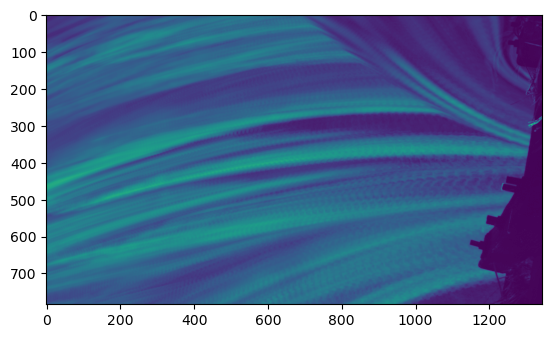

In [5]:
# Pixel-wise std
img_std = dropdims(Statistics.std(raw_imgs[:,:,:], dims = 3), dims = 3)
blur_std = zeros(size(img_std))
for n = 2:Img_dims[1]-1 # vertical dimension
    for m = 2:Img_dims[2]-1 # horizontal dimension
        blur_std[n,m] = Statistics.sum(img_std[n-1:n+1,m-1:m+1].*1/9)
    end
end

plt.imshow(img_std)#, vmin=0, vmax=100)
plt.show()

[ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
[ Info: Precompiling ImageEdgeDetection [2b14c160-480b-11ea-1b58-656063328ff7]


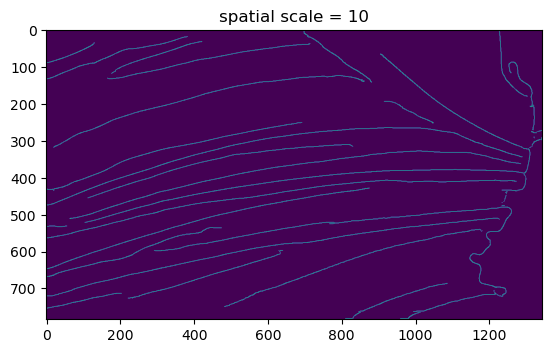

In [6]:
# Edge detection from std dev image
using Images, ImageEdgeDetection
using ImageEdgeDetection: Percentile
filter_rad = 10
alg = Canny(spatial_scale=filter_rad, high=Percentile(80), low=Percentile(20))
edges = detect_edges(img_std, alg)
mosaicview(img_std, edges; nrow=1)

testlinerange = [150:300,50:400]

plt.imshow(edges)#[testlinerange[1],testlinerange[2]])
plt.title("spatial scale = $filter_rad")
plt.show()

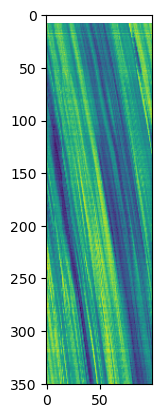

In [7]:
# STIV test on single edge in subwindow of image 
# select area of edge image
edge_subarea = edges[testlinerange[1],testlinerange[2]]
edge_subarea .= ifelse.(edge_subarea .== 0.0, NaN, edge_subarea) # 0's to NaNs
stiv_length = length(testlinerange[2])
# create empty STIV vector
stiv_vec = zeros(stiv_length, length(raw_imgs))
# stiv_vec = fill(nan,(stiv_length, length(raw_imgs))) # dims: length of STIV line (rows) x number of images (cols)
for i = 1:length(raw_imgs)
    raw_img_subarea = raw_imgs[i][testlinerange[1],testlinerange[2]]
    raw_img_edge = raw_img_subarea.*edge_subarea # mask raw image by edge output NaN/1
    stiv_vec[:,i] = NaNStatistics.nanmean(raw_img_edge, dims = 1)
end

plt.imshow(stiv_vec)
plt.show()


Number of labels: 2432
Singular matrix encountered for line with coordinates: CartesianIndex{2}[CartesianIndex(484, 1256), CartesianIndex(485, 1256), CartesianIndex(485, 1257)]
Singular matrix encountered for line with coordinates: CartesianIndex{2}[CartesianIndex(91, 1259), CartesianIndex(92, 1259), CartesianIndex(91, 1260)]


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


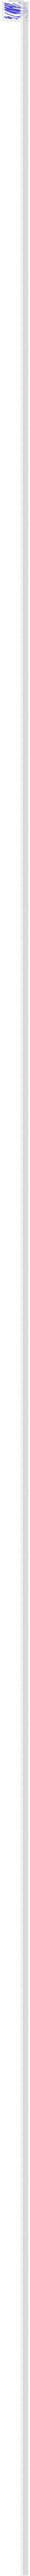

In [8]:
# Define functions for streamlines
using LinearAlgebra

edges_bin = map(Bool, edges .==1)

cc = label_components(edges_bin)

num_labels = maximum(cc)

println("Number of labels: ", num_labels)

lines = []
for label in 1:num_labels
    coords = findall(x -> x == label, cc)
    push!(lines, coords)
end

fitted_lines = []
for coords in lines
    # Extract x and y coordinates
    x_coords = [coord[2] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    
    if length(unique(x_coords)) == 1
        # Handle vertical line case
        fit_func = x -> y_coords[1]
    else
        try
            # Fit a second-order polynomial
            X = hcat(ones(length(x_coords)), x_coords, x_coords .^ 2) # Design matrix for quadratic fit
            β = X \ y_coords # Solve for coefficients using least squares
            fit_func = x -> β[1] + β[2] * x + β[3] * x^2 # Define the fitted function
        catch e
            if e isa SingularException
                # Handle the singular matrix exception
                println("Singular matrix encountered for line with coordinates: ", coords)
                continue
            else
                rethrow(e)
            end
        end
    end
    
    push!(fitted_lines, (x_coords, fit_func))
end

scatter_x = []
scatter_y = []
for coords in lines
    append!(scatter_x, [coord[2] for coord in coords])
    append!(scatter_y, [coord[1] for coord in coords])
end

plt.figure()
plt.scatter(scatter_x, scatter_y, label="Original Lines", color="blue")

# Overlay the fitted functions
for (x_coords, fit_func) in fitted_lines
    x_range = minimum(x_coords):maximum(x_coords)
    y_fitted = [fit_func(x) for x in x_range]
    plt.plot(x_range, y_fitted, label="Fitted Function", lw=2)
end

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Original Lines and Fitted Functions")
plt.show()


In [9]:
lines = []
for label in 1:num_labels
    coords = findall(x -> x == label, cc)
    push!(lines, (label, coords))
end
lines

2432-element Vector{Any}:
 (1, CartesianIndex{2}[CartesianIndex(92, 1), CartesianIndex(92, 2), CartesianIndex(92, 3)])
 (2, CartesianIndex{2}[CartesianIndex(136, 1), CartesianIndex(135, 2), CartesianIndex(136, 2), CartesianIndex(135, 3), CartesianIndex(135, 4), CartesianIndex(135, 5), CartesianIndex(135, 6)])
 (3, CartesianIndex{2}[CartesianIndex(477, 1), CartesianIndex(477, 2), CartesianIndex(476, 3), CartesianIndex(477, 3), CartesianIndex(476, 4), CartesianIndex(476, 5), CartesianIndex(476, 6), CartesianIndex(476, 7), CartesianIndex(476, 8)])
 (4, CartesianIndex{2}[CartesianIndex(534, 1), CartesianIndex(534, 2), CartesianIndex(534, 3), CartesianIndex(534, 4), CartesianIndex(534, 5), CartesianIndex(534, 6), CartesianIndex(534, 7), CartesianIndex(534, 8)])
 (5, CartesianIndex{2}[CartesianIndex(565, 1), CartesianIndex(565, 2), CartesianIndex(565, 3), CartesianIndex(565, 4), CartesianIndex(565, 5), CartesianIndex(565, 6), CartesianIndex(565, 7), CartesianIndex(565, 8)])
 (6, CartesianInd

In [14]:
raw_imgs.Metadata.Estimatedfps
label_components(edges)
edges_bin = map(Bool, edges .==1)
edges_bool
maximum(label_components(edges_bool))


LoadError: UndefVarError: `edges_bool` not defined